In [2]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
def load_dataset(file_path, text_column, label_column):
    df = pd.read_csv(file_path)
    texts = df[text_column].values
    labels = df[label_column].values
    return texts, labels

In [4]:
def split_dataset(texts, labels, test_size=0.2, random_state=42):
    return train_test_split(texts, labels, test_size=test_size, random_state=random_state)

In [5]:
def tokenize_data(tokenizer, texts, max_length=128):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
    return encodings['input_ids']

In [6]:
def build_model(pretrained_model_name, num_labels):
    model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_labels)
    return model

In [7]:
def compile_model(model, learning_rate=5e-5):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

In [8]:
def train_model(model, train_input_ids, train_labels, val_input_ids, val_labels, epochs=3, batch_size=16):
    history = model.fit(
        train_input_ids, 
        train_labels, 
        validation_data=(val_input_ids, val_labels),
        epochs=epochs,
        batch_size=batch_size
    )
    return history

In [9]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

In [10]:
def evaluate_model(model, input_ids, true_labels, class_names):
    y_pred = np.argmax(model.predict(input_ids)[0], axis=1)
    print("Classification Report:\n", classification_report(true_labels, y_pred))
    
    conf_matrix = confusion_matrix(true_labels, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(true_labels, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return y_pred

In [11]:
def save_predictions(texts, true_labels, predicted_labels, output_file):
    predictions_df = pd.DataFrame({
        'Text': texts,
        'True Label': true_labels,
        'Predicted Label': predicted_labels
    })
    predictions_df.to_csv(output_file, index=False)
    print(f"Predictions saved to '{output_file}'.")

In [12]:
def predict_on_new_data(model, tokenizer, new_test_file, text_column, output_file, max_length=128):
    new_test_data = pd.read_csv(new_test_file)
    if text_column not in new_test_data.columns:
        raise ValueError(f"Column '{text_column}' not found in the new test dataset.")
    new_test_texts = new_test_data[text_column].values
    new_test_encodings = tokenize_data(tokenizer, new_test_texts, max_length=max_length)
    new_predictions = np.argmax(model.predict(new_test_encodings)[0], axis=1)
    new_test_data['Class (Predicted Label)'] = new_predictions
    new_test_data.to_csv(output_file, index=False)
    print(f"New test predictions saved to '{output_file}'.")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


50/50 [==============================] - 117s 2s/step - loss: 0.7229 - accuracy: 0.7450 - val_loss: 0.6709 - val_accuracy: 0.7550
Epoch 2/3
50/50 [==============================] - 100s 2s/step - loss: 0.6415 - accuracy: 0.7700 - val_loss: 0.5364 - val_accuracy: 0.7550
Epoch 3/3
50/50 [==============================] - 102s 2s/step - loss: 0.5291 - accuracy: 0.7588 - val_loss: 0.4992 - val_accuracy: 0.8050


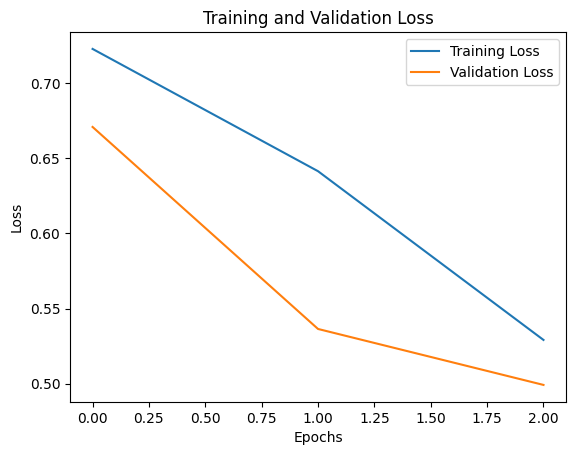

7/7 [==============================] - 8s 722ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.80      0.99      0.88       151
           2       0.92      0.26      0.41        42

    accuracy                           0.81       200
   macro avg       0.57      0.42      0.43       200
weighted avg       0.79      0.81      0.75       200



D:\miniconda\miniconda\envs\hate_speech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\miniconda\miniconda\envs\hate_speech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\miniconda\miniconda\envs\hate_speech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

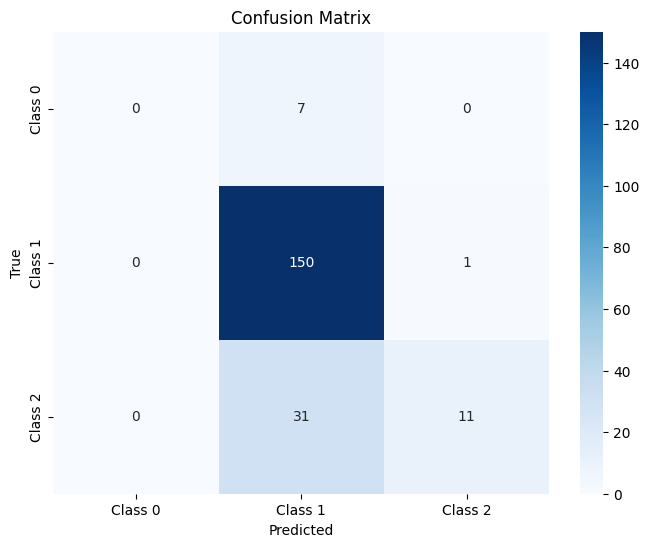

Accuracy: 80.50%


In [13]:
dataset_file = r"D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\data\cleaned_dataset\labeled_data_cleaned.csv"
output_predictions = "test_predictions.csv"

text_column = "corrected_tweet"
label_column = "class"

texts, labels = load_dataset(dataset_file, text_column, label_column)
X_train, X_test, y_train, y_test = split_dataset(texts, labels)

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
train_input_ids = tokenize_data(tokenizer, X_train)
test_input_ids = tokenize_data(tokenizer, X_test)

num_labels = len(set(labels))
model = build_model('bert-base-uncased', num_labels)
model = compile_model(model)

history = train_model(model, train_input_ids, y_train, test_input_ids, y_test)
plot_loss(history)

y_pred = evaluate_model(model, test_input_ids, y_test, class_names=["Class 0", "Class 1", "Class 2"])
#save_predictions(X_test, y_test, y_pred, output_predictions)



In [14]:
test_file = r"D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\data\cleaned_dataset\labeled_data_cleaned_test.csv"
new_test_predictions = r"D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\data\cleaned_dataset\predictions_test.csv"
predict_on_new_data(model, tokenizer, test_file, text_column, new_test_predictions)

32/32 [==============================] - 27s 764ms/step
New test predictions saved to 'D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\data\cleaned_dataset\predictions_test.csv'.
